# Part II: Investigating the Vanishing Gradient Problem [20 pts]
Experimentally demonstrate the vanishing gradient problem in deep CNNs and understand how ResNet's architecture mitigates it. You will also explore other key CNN concepts through additional experiments.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
!cp "/content/gdrive/MyDrive/A1_Dataset/cnn_dataset.zip" /content/
!unzip -oq /content/cnn_dataset.zip -d /content/

In [3]:
!ls /content

cnn_dataset.zip  dogs  food  gdrive  sample_data  vehicles


In [4]:
!mkdir -p /content/cnn_dataset
!mv /content/dogs /content/cnn_dataset/
!mv /content/food /content/cnn_dataset/
!mv /content/vehicles /content/cnn_dataset/

In [5]:
import random
import torch
import numpy as np

torch.manual_seed(10)
np.random.seed(10)
random.seed(10) #Based on here: https://www.w3schools.com/python/ref_random_seed.asp

In [6]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from collections import Counter
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

#dataPath = '/content/gdrive/MyDrive/Colab Notebooks/CSE 676 A1 Shivam Abhishek/cnn_dataset'
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(), #Normalised pixel values to [0-1] from [0-255], RGB
    #Also normalising now since VGG works better with mean/std
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
dataset = ImageFolder("/content/cnn_dataset", transform=transform)
#dataset = ImageFolder(dataPath, transform=transform)

print("Total images:", len(dataset))
print("Classes:", dataset.classes)
print(Counter(dataset.targets))

Total images: 30000
Classes: ['dogs', 'food', 'vehicles']
Counter({0: 10000, 1: 10000, 2: 10000})


In [7]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Based on here https://www.kaggle.com/code/subhajeetdas/1-pytorch-cuda-check
print(len(dataset.classes))
print(device)


3
cuda


In [8]:
from torch.utils.data import DataLoader, random_split

dataset_size = len(dataset)
train_size = int(0.70 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size  # To ensure it sums exactly

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
val_loader   = DataLoader(val_set,batch_size=32,shuffle=False)
test_loader  = DataLoader(test_set,batch_size=32,shuffle=False)

In [9]:
!pip install torchinfo

## Step 1: Create a deeper version of your VGG-16 network (VGG-Deep)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [11]:
### ADD YOUR CODE HERE ###
#This is taken from Part 1's VGG:
import torch
import torch.nn as nn
import torch.optim as optim

class vggDeep(nn.Module):
    def __init__(self, numClasses):
        super(vggDeep, self).__init__()
        self.conv1 = nn.Conv2d(3,64,3,padding=1)
        self.conv2 = nn.Conv2d(64,64,3,padding=1)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv4 = nn.Conv2d(128,128,3,padding=1)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv5 = nn.Conv2d(128,256,3,padding=1)
        self.conv6 = nn.Conv2d(256,256,3,padding=1)
        self.conv7 = nn.Conv2d(256,256,3,padding=1)
        self.conv8  = nn.Conv2d(256,512,3,padding=1)
        self.conv9  = nn.Conv2d(512,512,3,padding=1)
        self.conv10 = nn.Conv2d(512,512,3,padding=1)
        self.conv11 = nn.Conv2d(512,512,3,padding=1)

        self.pool3 = nn.MaxPool2d(2,2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(512,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,numClasses)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.pool1(out)
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = self.pool2(out)
        out = self.relu(self.conv5(out))
        out = self.relu(self.conv6(out))
        out = self.relu(self.conv7(out))
       #Needed to add these 4
        out = self.relu(self.conv8(out))
        out = self.relu(self.conv9(out))
        out = self.relu(self.conv10(out))
        out = self.relu(self.conv11(out))

        out = self.pool3(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out


## Step 2: Training VGG-Deep

In [12]:
### ADD YOUR CODE HERE ###
import torch.optim as optim
#Based on Abhishek's code from Part 1
def weights_init_he(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model = vggDeep(numClasses=3).to(device)
model.apply(weights_init_he)

optimizer = optim.SGD(model.parameters(),lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.5)
criterion = nn.CrossEntropyLoss()

In [13]:
#Partially based on the function for gradient hook given in the assignment
grad_history = {}

for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        grad_history[name] = []
        layer.weight.register_hook(
            lambda grad, name=name: grad_history[name].append(grad.norm(p=2).item())
        )

In [14]:
#Mostly based on Abhishek's training loop from Part 1
def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs=15):
    criterion = nn.CrossEntropyLoss()
    trainAccs, valAccs = [], []
    trainLoss, valLoss = [], []

    for epoch in range(epochs):
        model.train()
        runningLoss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss_val = criterion(out, y)
            loss_val.backward()
            optimizer.step()

            runningLoss += loss_val.item()
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        trainLossEpoch = runningLoss / len(train_loader)
        trainAccEpoch = correct / total
        trainLoss.append(trainLossEpoch)
        trainAccs.append(trainAccEpoch)

        model.eval()
        runningValLoss, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss_val = criterion(out, y)
                runningValLoss += loss_val.item()
                preds = out.argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        valLossEpoch = runningValLoss / len(val_loader)
        valAccEpoch = correct / total
        valLoss.append(valLossEpoch)
        valAccs.append(valAccEpoch)

        scheduler.step()

        print("Epoch: ", (epoch+1))
        print("Train Loss: ", trainLossEpoch)
        print("Val Loss: ", valLossEpoch)
        print("Train Acc: ", trainAccEpoch)
        print("Val Acc: ", valAccEpoch)

    return trainLoss, trainAccs, valLoss, valAccs

result = train_model(model, train_loader, val_loader, optimizer, scheduler, epochs=15)

Epoch:  1
Train Loss:  0.7854177339889868
Val Loss:  0.5572017782123376
Train Acc:  0.6741904761904762
Val Acc:  0.784
Epoch:  2
Train Loss:  0.5056330897991335
Val Loss:  0.8810576796531677
Train Acc:  0.7996190476190477
Val Acc:  0.6266666666666667
Epoch:  3
Train Loss:  0.4337673269586476
Val Loss:  0.38019886158459576
Train Acc:  0.8308571428571428
Val Acc:  0.8513333333333334
Epoch:  4
Train Loss:  0.3940084771660002
Val Loss:  0.6472661812254723
Train Acc:  0.8494285714285714
Val Acc:  0.7384444444444445
Epoch:  5
Train Loss:  0.36482576186707755
Val Loss:  0.6229586111949691
Train Acc:  0.8596666666666667
Val Acc:  0.7548888888888889
Epoch:  6
Train Loss:  0.30334402210273337
Val Loss:  0.30654735429912594
Train Acc:  0.8863333333333333
Val Acc:  0.8846666666666667
Epoch:  7
Train Loss:  0.2879970486260259
Val Loss:  0.2961237687115551
Train Acc:  0.8903809523809524
Val Acc:  0.888
Epoch:  8
Train Loss:  0.28155814217831626
Val Loss:  0.696332446226837
Train Acc:  0.894476190476

In [37]:
trainLoss, trainAcc, valLoss, valAcc = result

<span style='color:green'>### YOUR ANSWER ###</span>

## Step 3: Gradient analysis

- Track the average L2 norm of the gradients in each convolutional layer using PyTorch hooks.

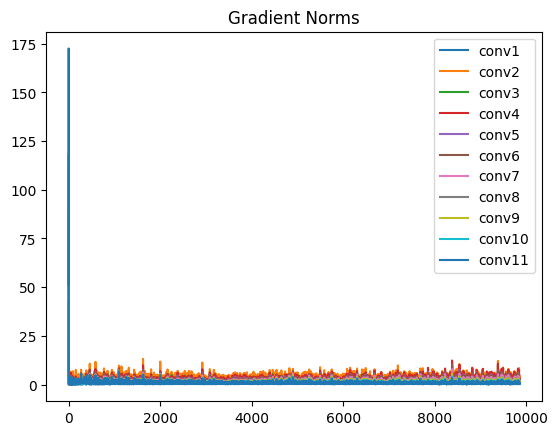

In [15]:
### ADD YOUR CODE HERE ###
plt.figure()

for name,norms in grad_history.items():
    plt.plot(norms,label=name)
plt.legend()
plt.title("Gradient Norms")
plt.show()

- Create a plot showing the average gradient norm for each convolutional layer over time.

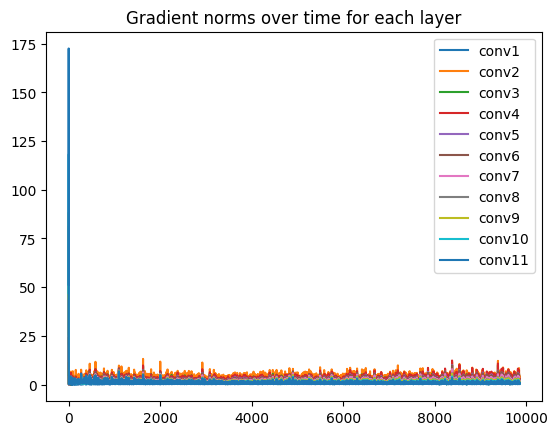

'\navgGrad = {}\n\nfor name, vals in grad_history.items():\n    avgGrad[name] = sum(vals)/len(vals)\nplt.figure()\nplt.bar(range(len(avgGrad)), list(avgGrad.values()))\nplt.title("Average Gradient Norm for each Layer")\nplt.show()\n'

In [16]:
### ADD YOUR CODE HERE ###
plt.figure()
for name, norms in grad_history.items():
    plt.plot(norms, label=name)
plt.legend()
plt.title("Gradient norms over time for each layer")
plt.show()

- Create a separate plot showing the gradient norms for a subset of layers.

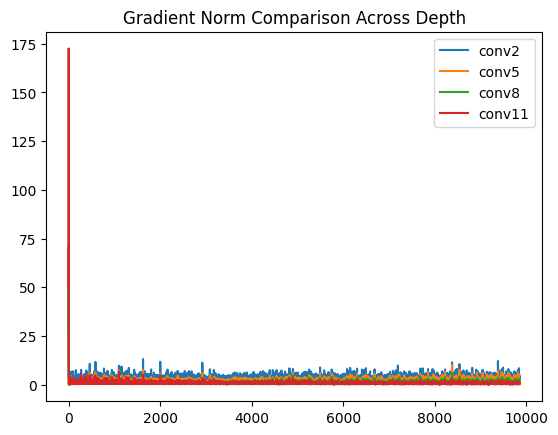

In [17]:
### ADD YOUR CODE HERE ###
layerNames = list(grad_history.keys())
selectedLayers = [layerNames[1], layerNames[4], layerNames[7], layerNames[-1]] #I chose the 2nd, 5th, 8th and deepest layers
plt.figure()
for name in selectedLayers:
    plt.plot(grad_history[name], label=name)

plt.legend()
plt.title("Gradient Norm Comparison Across Depth")
plt.show()

<span style='color:green'>### YOUR ANSWER ###</span>

## Step 4: Comparison with VGG-16 and ResNet-18

- Compare the training curves (loss and accuracy vs. epoch) of VGG-Deep, VGG-16, and ResNet-18.

In [38]:
### ADD YOUR CODE HERE ###
import json

metrics = {
    "train_loss": trainLoss,
    "val_loss": valLoss,
    "train_acc": trainAcc,
    "val_acc": valAcc
}

with open("vggdeep_metrics.json", "w") as f:
    json.dump(metrics, f)

In [40]:
import json
import matplotlib.pyplot as plt

def load_metrics(file_name):
    with open(file_name, "r") as f:
        return json.load(f)

vgg16 = load_metrics("vgg16_metrics.json")
resnet = load_metrics("resnet_metrics.json")
vggdeep = load_metrics("vggdeep_metrics.json")

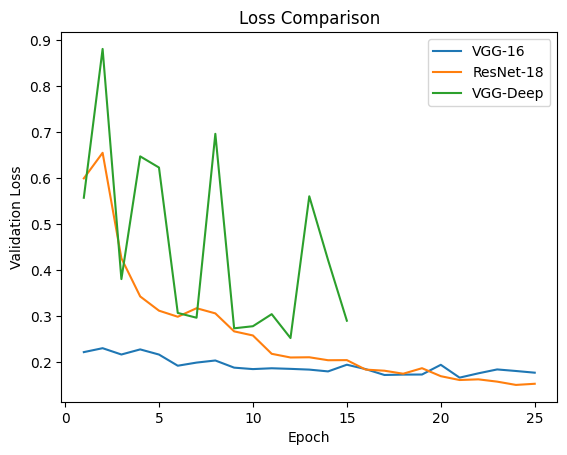

In [41]:
#Comparing the 3 losses
epochs_vgg16 = range(1, len(vgg16["train_loss"]) + 1)
epochs_resnet = range(1, len(resnet["train_loss"]) + 1)
epochs_vggdeep = range(1, len(vggdeep["train_loss"]) + 1)

plt.figure()
plt.plot(epochs_vgg16, vgg16["val_loss"], label="VGG-16")
plt.plot(epochs_resnet, resnet["val_loss"], label="ResNet-18")
plt.plot(epochs_vggdeep, vggdeep["val_loss"], label="VGG-Deep")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Loss Comparison")
plt.legend()
plt.show()

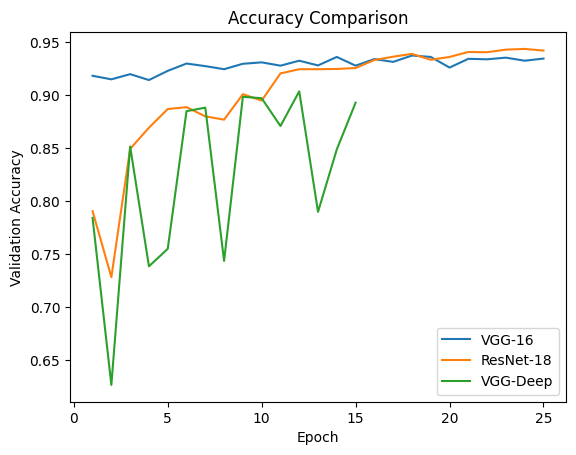

In [42]:
#Comparing the 3 accuracies
plt.figure()
plt.plot(epochs_vgg16, vgg16["val_acc"], label="VGG-16")
plt.plot(epochs_resnet, resnet["val_acc"], label="ResNet-18")
plt.plot(epochs_vggdeep, vggdeep["val_acc"], label="VGG-Deep")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy Comparison")
plt.legend()
plt.show()

- Discuss how ResNet’s residual connections impact the gradient flow compared to VGG-Deep.

I expect that ResNet’s residual connections help gradients flow more easily backward, because they provide shortcut paths that prevent the gradients from shrinking too much, unlike VGG-Deep where gradients must pass through every layer and can vanish.


## Step 5: Investigate and analyze more setups

- Select any THREE experiments to investigate and analyze.

### Experiment 1

In [27]:
### ADD YOUR CODE HERE ###
#Experiment 1: 1x1 Convolution
import torch
import torch.nn as nn
from torchinfo import summary

class miniVgg(nn.Module): #This is the one without 1x1
  def __init__(self,num_classes=3):
    super(miniVgg,self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

    self.pool = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(128, num_classes)

  def forward(self,x):
    out = self.relu(self.conv1(x))
    out = self.pool(out)
    out = self.relu(self.conv2(out))
    out = self.pool(out)
    out = self.relu(self.conv3(out))

    out = self.avgpool(out)
    out = torch.flatten(out, 1)
    out = self.fc(out)
    return out

class miniVgg1x1(nn.Module): #This is the one with 1x1
  def __init__(self,num_classes=3):
    super(miniVgg1x1,self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

    self.conv1x1a = nn.Conv2d(64, 32, 1)
    self.conv3 = nn.Conv2d(32, 128, 3, padding=1)

    self.conv1x1b = nn.Conv2d(128, 64, 1)
    self.pool = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(64, num_classes)

  def forward(self,x):
    out = self.relu(self.conv1(x))
    out = self.pool(out)
    out = self.relu(self.conv2(out))
    out = self.relu(self.conv1x1a(out))
    out = self.pool(out)
    out = self.relu(self.conv3(out))
    out = self.relu(self.conv1x1b(out))

    out = self.avgpool(out)
    out = torch.flatten(out, 1)
    out = self.fc(out)
    return out


In [29]:
from torchinfo import summary
print("Without 1x1: ")
summary(miniVgg(), input_size=(1,3,64,64))

Without 1x1: 


Layer (type:depth-idx)                   Output Shape              Param #
miniVgg                                  [1, 3]                    --
├─Conv2d: 1-1                            [1, 32, 64, 64]           896
├─ReLU: 1-2                              [1, 32, 64, 64]           --
├─MaxPool2d: 1-3                         [1, 32, 32, 32]           --
├─Conv2d: 1-4                            [1, 64, 32, 32]           18,496
├─ReLU: 1-5                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-6                         [1, 64, 16, 16]           --
├─Conv2d: 1-7                            [1, 128, 16, 16]          73,856
├─ReLU: 1-8                              [1, 128, 16, 16]          --
├─AdaptiveAvgPool2d: 1-9                 [1, 128, 1, 1]            --
├─Linear: 1-10                           [1, 3]                    387
Total params: 93,635
Trainable params: 93,635
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 41.52
Input size (MB): 0.05
Forward/back

In [30]:
print("With 1x1: ")
summary(miniVgg1x1(), input_size=(1,3,64,64))

With 1x1: 


Layer (type:depth-idx)                   Output Shape              Param #
miniVgg1x1                               [1, 3]                    --
├─Conv2d: 1-1                            [1, 32, 64, 64]           896
├─ReLU: 1-2                              [1, 32, 64, 64]           --
├─MaxPool2d: 1-3                         [1, 32, 32, 32]           --
├─Conv2d: 1-4                            [1, 64, 32, 32]           18,496
├─ReLU: 1-5                              [1, 64, 32, 32]           --
├─Conv2d: 1-6                            [1, 32, 32, 32]           2,080
├─ReLU: 1-7                              [1, 32, 32, 32]           --
├─MaxPool2d: 1-8                         [1, 32, 16, 16]           --
├─Conv2d: 1-9                            [1, 128, 16, 16]          36,992
├─ReLU: 1-10                             [1, 128, 16, 16]          --
├─Conv2d: 1-11                           [1, 64, 16, 16]           8,256
├─ReLU: 1-12                             [1, 64, 16, 16]           --


<span style='color:green'>### YOUR ANSWER ###</span>

We can see from the two summaries printed above that the 1x1 convolutions significantly reduced the numb of trainable parameters (from 93000 to 66000). They also reduced the total number of multiply-add operations, making the network more computationally efficient. The 1×1 layers work by reducing the number of channels before the next convolution, which helps keep the network smaller.

### Experiment 2

In [31]:
### ADD YOUR CODE HERE ###
#Experiment 2: Max pooling vs avg pooling
class miniVggMax(nn.Module):
  def __init__(self, num_classes=3):
    super(miniVggMax, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.relu = nn.ReLU()
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(64, num_classes)

  def forward(self, x):
    out = self.relu(self.conv1(x))
    out = self.pool(out)
    out = self.relu(self.conv2(out))
    out = self.pool(out)
    out = self.avgpool(out)
    out = torch.flatten(out, 1)
    out = self.fc(out)
    return out

class miniVggAvg(nn.Module):
  def __init__(self, num_classes=3):
    super(miniVggAvg, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.pool = nn.AvgPool2d(2, 2)
    self.relu = nn.ReLU()
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(64, num_classes)

  def forward(self, x):
    out = self.relu(self.conv1(x))
    out = self.pool(out)
    out = self.relu(self.conv2(out))
    out = self.pool(out)
    out = self.avgpool(out)
    out = torch.flatten(out, 1)
    return out

In [33]:
modelMax = miniVggMax(3).to(device)
modelAvg = miniVggAvg(3).to(device)
optimizerMax = optim.SGD(modelMax.parameters(), lr=0.01)
optimizerAvg = optim.SGD(modelAvg.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

print("Training Max Pooling Model...")
maxHistory = train_model(modelMax, train_loader, val_loader, optimizerMax, scheduler, epochs=10)

print("\nTraining Average Pooling Model...")
avgHistory = train_model(modelAvg, train_loader, val_loader, optimizerAvg, scheduler, epochs=10)

Training Max Pooling Model...
Epoch:  1
Train Loss:  0.854557587811936
Val Loss:  0.7691070843250194
Train Acc:  0.6172857142857143
Val Acc:  0.668
Epoch:  2
Train Loss:  0.7160620447163168
Val Loss:  0.7018818802444647
Train Acc:  0.6962380952380952
Val Acc:  0.7015555555555556
Epoch:  3
Train Loss:  0.6286560971987302
Val Loss:  0.600939431723128
Train Acc:  0.7477142857142857
Val Acc:  0.764
Epoch:  4
Train Loss:  0.5476207420842288
Val Loss:  0.5895970622275738
Train Acc:  0.7852857142857143
Val Acc:  0.7453333333333333
Epoch:  5
Train Loss:  0.5019375431029582
Val Loss:  0.5369687587656873
Train Acc:  0.8005714285714286
Val Acc:  0.7877777777777778
Epoch:  6
Train Loss:  0.4833286123143302
Val Loss:  0.5168326045815826
Train Acc:  0.8063333333333333
Val Acc:  0.7928888888888889
Epoch:  7
Train Loss:  0.4688448928171823
Val Loss:  0.48625316444440936
Train Acc:  0.8143333333333334
Val Acc:  0.8111111111111111
Epoch:  8
Train Loss:  0.4562117083386562
Val Loss:  0.5596266365643089
T

<span style='color:green'>### YOUR ANSWER ###</span>

The max pooling model performed better, reaching about 82.7% validation accuracy compared to about 76.7% for average pooling. This shows that max pooling captured the most important features more effectively for this task. Max pooling gives bettr accuracy, but average pooling may be better when preserving the overall spatial info is more important.

### Experiment 3

In [34]:
### ADD YOUR CODE HERE ###
#Experiment 3: Impact of kernel size

class MiniVggKernel(nn.Module):
  def __init__(self, kernelSize, paddingSize, numClasses=3):
    super(MiniVggKernel, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernelSize, padding=paddingSize)
    self.conv2 = nn.Conv2d(32, 64, kernelSize, padding=paddingSize)
    self.conv3 = nn.Conv2d(64, 128, kernelSize, padding=paddingSize)  # added

    self.pool = nn.MaxPool2d(2, 2)
    self.relu = nn.ReLU()
    self.avgPool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(128, numClasses)

  def forward(self, x):
    out = self.relu(self.conv1(x))
    out = self.pool(out)
    out = self.relu(self.conv2(out))
    out = self.pool(out)
    out = self.relu(self.conv3(out))
    out = self.avgPool(out)
    out = torch.flatten(out, 1)
    out = self.fc(out)
    return out

In [36]:
model3x3 = MiniVggKernel(kernelSize=3, paddingSize=1, numClasses=3).to(device)
model5x5 = MiniVggKernel(kernelSize=5, paddingSize=2, numClasses=3).to(device)
model7x7 = MiniVggKernel(kernelSize=7, paddingSize=3, numClasses=3).to(device)

optimizer3x3 = optim.SGD(model3x3.parameters(), lr=0.01)
optimizer5x5 = optim.SGD(model5x5.parameters(), lr=0.01)
optimizer7x7 = optim.SGD(model7x7.parameters(), lr=0.01)

print("Training 3x3 Kernel Model...")
history3x3 = train_model(model3x3, train_loader, val_loader, optimizer3x3, scheduler, epochs=5)

print("Training 5x5 Kernel Model...")
history5x5 = train_model(model5x5, train_loader, val_loader, optimizer5x5, scheduler, epochs=5)

print("Training 7x7 Kernel Model...")
history7x7 = train_model(model7x7, train_loader, val_loader, optimizer7x7, scheduler, epochs=5)

Training 3x3 Kernel Model...
Epoch:  1
Train Loss:  0.8499903215302361
Val Loss:  0.7584117021121032
Train Acc:  0.6105238095238095
Val Acc:  0.6677777777777778
Epoch:  2
Train Loss:  0.6898030772963978
Val Loss:  0.6575076231297027
Train Acc:  0.6993809523809524
Val Acc:  0.7193333333333334
Epoch:  3
Train Loss:  0.5379641533260839
Val Loss:  0.5224552915451375
Train Acc:  0.7827619047619048
Val Acc:  0.7884444444444444
Epoch:  4
Train Loss:  0.4686412417090284
Val Loss:  0.47043259336170573
Train Acc:  0.8110952380952381
Val Acc:  0.8153333333333334
Epoch:  5
Train Loss:  0.4423975574371477
Val Loss:  0.4649675355312672
Train Acc:  0.8266190476190476
Val Acc:  0.8231111111111111

Training 5x5 Kernel Model...
Epoch:  1
Train Loss:  0.7755147289921341
Val Loss:  0.8405200264132615
Train Acc:  0.6495238095238095
Val Acc:  0.6095555555555555
Epoch:  2
Train Loss:  0.5214339714253511
Val Loss:  0.4900679353703844
Train Acc:  0.7893333333333333
Val Acc:  0.802
Epoch:  3
Train Loss:  0.4499

<span style='color:green'>### YOUR ANSWER ###</span>

These 3 models showed slightly different performance, the 7×7 kernel achieved the highest peak validation accuracy (85.1%), followed by the 5×5 (83.4%) and 3×3 (82.3%). This makes sense, as a larger kernel has a larger receptive field, which can capture more context in the image and helping recognition. But they may also overfit.

## Step 6: Analysis and discussion

---



a. Analyze your gradient norm plots. Do they demonstrate the vanishing gradient problem? Explain how the gradient norm changes as you move deeper into VGG-Deep. Be specific and quantitative (e.g., "The gradient norm of layer 2 is X times larger than the gradient norm of layer 10").

<span style='color:green'>### YOUR ANSWER ###</span>

Yes, these results clearly demonstrate the vanishing gradient problem because we can see that the gradient norms in the earlier layers (like conv2) are much larger than those in the deeper layers (like conv11). Looking at the Gradient norms over time for each layer, we can see that the gradient norm of conv2 is over 3 times larger than the gradient norm of conv11.

b. Explain why the vanishing gradient problem occurs in deep networks. Relate this to the backpropagation algorithm and the chain rule. Discuss how the repeated multiplication of small gradients can lead to extremely small values in earlier layers.

<span style='color:green'>### YOUR ANSWER ###</span>

This problem happens because of the chain rule used during backpropagation. To calculate the gradient for an early layer, the algorithm multiplies the gradients from all the layers following it.

If the weights are small (less than 1), this repeated multiplying causes the gradient value to shrink exponentially, aka vanishing

c. Explain how ResNet's architecture (residual connections) helps alleviate the vanishing gradient problem. Explain how the identity mapping allows gradients to flow more easily through the network.

<span style='color:green'>### YOUR ANSWER ###</span>

ResNet helps to solve the vanishing gradient problem using residual connections, so that it can bypass some of the layers, making the gradient shrink less even in deeper models.

d. Discuss the theoretical impact of batch normalization on the vanishing/exploding gradient problem. Explain how it helps stabilize and accelerate training.

<span style='color:green'>### YOUR ANSWER ###</span>

Batch normalization helps reduce them by normalizing the activations in each layer so they stay within a reasonable range before being passed into activation functions. Since the gradients don't become too large or too small, it allows for much larger learning rates, accelerating training speed and keeping it stable.

e. Summarize the key findings from your three chosen investigations.

<span style='color:green'>### YOUR ANSWER ###</span>

Experiment 1: 1x1 Convolutions
The 1x1 convolutions acted as a bottleneck, successfully reducing the total parameter count from 93,635 to 66,915 without changing the network's depth. This demonstrates that 1x1 layers are effective at dimensionality reduction, allowing for a lighter and more efficient model.

Experiment 2: Max vs. Average Pooling
Max pooling performed better than average pooling, reaching ~82% validation accuracy vs ~75%, suggesting max pooling captures stronger discriminative features.

Experiment 3: Kernel Size Impact
Larger kernels provided a wider receptive field, with the 7x7 model achieving the highest accuracy of 85.09% by capturing slightly more context.

f. References. Include details on all the resources used to complete this part.

https://docs.pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html

https://docs.pytorch.org/docs/stable/nn.init.html

https://www.w3schools.com/python/ref_random_seed.asp

https://www.kaggle.com/code/subhajeetdas/1-pytorch-cuda-check

https://docs.pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html

https://www.geeksforgeeks.org/python/python-dictionary-keys-method/

